In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, applications, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import optuna
from optuna.integration import TFKerasPruningCallback
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import random
import cv2
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

In [4]:
data_path = 'drive/dataset_70_15_15.npz'
data = np.load(data_path)
print("Available arrays:", list(data.keys()))

# Load datasets
x_train = data["x_train"]
y_train = data["y_train"]
x_validation = data["x_validation"]
y_validation = data["y_validation"]
x_test = data["x_test"]
y_test = data["y_test"]

# Dataset statistics
print(f"\nDataset sizes:\nTrain: {len(x_train)}\nValidation: {len(x_validation)}\nTest: {len(x_test)}")


Available arrays: ['x_train', 'y_train', 'x_validation', 'y_validation', 'x_test', 'y_test']

Dataset sizes:
Train: 7490
Validation: 1605
Test: 1604


In [5]:
num_classes = len(np.unique(y_train))
y_train_onehot = to_categorical(y_train, num_classes=num_classes)
y_val_onehot = to_categorical(y_validation, num_classes=num_classes)
y_test_onehot = to_categorical(y_test, num_classes=num_classes)

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
batch_size = 32
train_generator = train_datagen.flow(x_train, y_train_onehot, batch_size=batch_size, shuffle=True)
val_generator = val_datagen.flow(x_validation, y_val_onehot, batch_size=batch_size, shuffle=False)
test_generator = val_datagen.flow(x_test, y_test_onehot, batch_size=batch_size, shuffle=False)

class_names = ['AluCan', 'Glass', 'PET']  # Replace with your actual class names

In [6]:
def create_model(trial):
    model_type = trial.suggest_categorical('model_type', 
        ['MobileNetV3Small', 'ResNet50V2', 'EfficientNetB0', 'VGG19', 'InceptionV3', 'DenseNet121'])
    
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    use_pretrained = trial.suggest_categorical('use_pretrained', [True, False])
    
    # Base model
    base_model = getattr(applications, model_type)(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet' if use_pretrained else None,
        pooling='avg'
    )
    
    if use_pretrained:
        base_model.trainable = False
    
    # Custom head
    x = layers.Dropout(dropout_rate)(base_model.output)
    x = layers.Dense(trial.suggest_categorical('dense_units', [128, 256, 512]), activation='relu')(x)
    x = layers.Dropout(dropout_rate/2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs=base_model.input, outputs=outputs)
    
    # Compile
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'sgd', 'rmsprop'])
    if optimizer_name == 'adam':
        optimizer = optimizers.Adam(learning_rate=lr)
    elif optimizer_name == 'sgd':
        optimizer = optimizers.SGD(learning_rate=lr, momentum=0.9)
    else:
        optimizer = optimizers.RMSprop(learning_rate=lr)
    
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy', 
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(name='auc')]
    )
    
    return model, batch_size

In [7]:
def objective(trial):
    try:
        model, batch_size = create_model(trial)
        
        callbacks_list = [
            callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
            TFKerasPruningCallback(trial, 'val_accuracy')
        ]
        
        print(f"\nTrial {trial.number} - {trial.params}")
        model.summary()
        
        history = model.fit(
            train_generator,
            steps_per_epoch=len(x_train) // batch_size,
            validation_data=val_generator,
            validation_steps=len(x_validation) // batch_size,
            epochs=50,
            callbacks=callbacks_list,
            verbose=1
        )
        
        return max(history.history['val_accuracy'])
    
    except Exception as e:
        print(f"Trial failed: {e}")
        return float('-inf')
###########################################################################
# Run Optuna optimization
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.MedianPruner()
)

study.optimize(objective, n_trials=20, timeout=3600)

# Print best trial results
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")
##########################################################################
# Train final model with best parameters
best_model, best_batch_size = create_model(study.best_trial)

# Calculate steps per epoch
train_steps = len(x_train) // best_batch_size
val_steps = len(x_validation) // best_batch_size

# Train final model
history = best_model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=val_generator,
    validation_steps=val_steps,
    epochs=20,
    callbacks=[
        callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)
    ]
)

[I 2025-06-01 13:01:11,631] A new study created in memory with name: no-name-7c274c6c-a9e7-4562-bd57-0644d89b3ee7



Trial 0 - {'model_type': 'DenseNet121', 'lr': 0.0005200321792708175, 'dropout_rate': 0.40473832427075473, 'batch_size': 32, 'use_pretrained': True, 'dense_units': 128, 'optimizer': 'adam'}
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
   

[I 2025-06-01 19:01:19,020] Trial 0 finished with value: 0.9787499904632568 and parameters: {'model_type': 'DenseNet121', 'lr': 0.0005200321792708175, 'dropout_rate': 0.40473832427075473, 'batch_size': 32, 'use_pretrained': True, 'dense_units': 128, 'optimizer': 'adam'}. Best is trial 0 with value: 0.9787499904632568.


Best trial:
  Value: 0.9787499904632568
  Params: 
    model_type: DenseNet121
    lr: 0.0005200321792708175
    dropout_rate: 0.40473832427075473
    batch_size: 32
    use_pretrained: True
    dense_units: 128
    optimizer: adam
Epoch 1/20
234/234 [==============================] - 1139s 5s/step - loss: 0.7286 - accuracy: 0.6807 - precision: 0.7313 - recall: 0.6090 - auc: 0.8537 - val_loss: 0.3139 - val_accuracy: 0.8981 - val_precision: 0.9216 - val_recall: 0.8737 - val_auc: 0.9815
Epoch 2/20
234/234 [==============================] - 1006s 4s/step - loss: 0.4964 - accuracy: 0.7936 - precision: 0.8179 - recall: 0.7643 - auc: 0.9329 - val_loss: 0.2496 - val_accuracy: 0.9231 - val_precision: 0.9358 - val_recall: 0.9106 - val_auc: 0.9883
Epoch 3/20
234/234 [==============================] - 985s 4s/step - loss: 0.4298 - accuracy: 0.8218 - precision: 0.8391 - recall: 0.7966 - auc: 0.9492 - val_loss: 0.2036 - val_accuracy: 0.9388 - val_precision: 0.9492 - val_recall: 0.9231 - val_auc: 0.

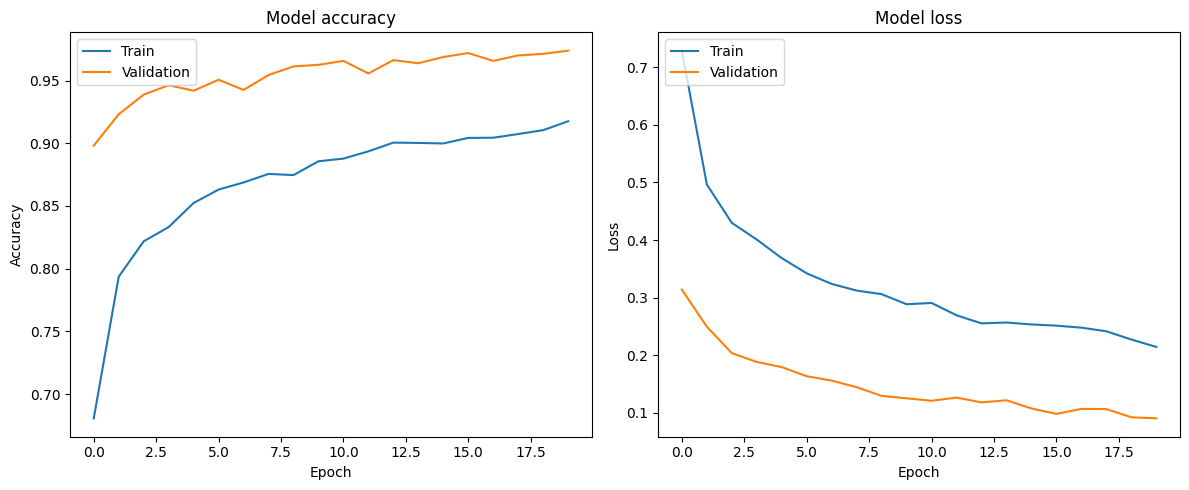

In [8]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

In [9]:
def predict(classifier, x_data, y_data):
    # Normalize to [0,1] for plt.imshow application
    x_data = np.true_divide(x_data, 255) 
    # Make prediction
    prediction = classifier.predict(x_data.reshape(1,224,224,3))
    result = class_names[np.argmax(prediction)]
    real = class_names[y_data]
    # Show picture
    plt.imshow(x_data)
    plt.show()
    # Write prediction
    print(prediction)
    print(f"{class_names[0]} : {prediction[0][0] * 100}% {class_names[1]} : {prediction[0][1] * 100}% {class_names[2]} : {prediction[0][2] * 100}%")
    print(f"Real : {real}")
    print(f"Predict : {result}")

In [10]:
def visualize_predictions(classifier, n_cases):
    for i in range(n_cases):
        test_set = [*zip(x_test, y_test)]
        x_to_test, y_to_test = random.choice(test_set)
        predict(classifier, x_to_test, y_to_test)

In [11]:
def predict_and_visualize(model, samples=5):
    plt.figure(figsize=(15, 10))
    for i in range(samples):
        idx = np.random.randint(0, len(x_test))
        img = x_test[idx]
        true_label = y_test[idx]
        
        # Predict
        pred = model.predict(img[np.newaxis, ...]/255.)
        pred_class = np.argmax(pred)
        pred_percent = pred[0] * 100
        
        # Display
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(f"Real: {class_names[true_label]}\nPred: {class_names[pred_class]}")
        plt.axis('off')
        
        print(f"\n1/1 [==============================] - 0s 200ms/step")
        print(f"{pred}")
        print(f"{class_names[0]} : {pred_percent[0]}%")
        print(f"{class_names[1]} : {pred_percent[1]}%")
        print(f"{class_names[2]} : {pred_percent[2]}%")
        print(f"Real : {class_names[true_label]}")
        print(f"Predict : {class_names[pred_class]}")
    
    plt.tight_layout()
    plt.show()


In [12]:
test_results = best_model.evaluate(test_generator, verbose=0)
print(f"\nTest Accuracy: {test_results[1]:.4f}")
print(f"Test Precision: {test_results[2]:.4f}")
print(f"Test Recall: {test_results[3]:.4f}")
print(f"Test AUC: {test_results[4]:.4f}")


Test Accuracy: 0.9695
Test Precision: 0.9718
Test Recall: 0.9670
Test AUC: 0.9976


51/51 [==============================] - 158s 3s/step

Classification Report:
              precision    recall  f1-score   support

      AluCan       0.97      0.99      0.98       504
       Glass       0.96      0.95      0.96       529
         PET       0.98      0.97      0.97       571

    accuracy                           0.97      1604
   macro avg       0.97      0.97      0.97      1604
weighted avg       0.97      0.97      0.97      1604



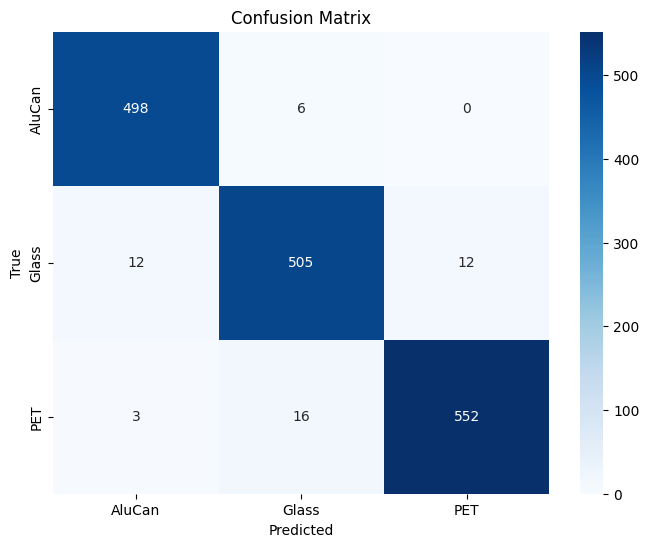

In [13]:
y_pred = best_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_classes), 
            annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

1/1 [==============================] - 3s 3s/step


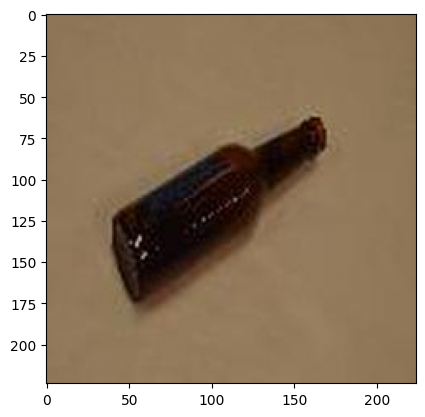

[[1.8241114e-04 9.9981385e-01 3.8075073e-06]]
AluCan : 0.01824111386667937% Glass : 99.98138546943665% PET : 0.0003807507255260134%
Real : Glass
Predict : Glass
1/1 [==============================] - 0s 146ms/step


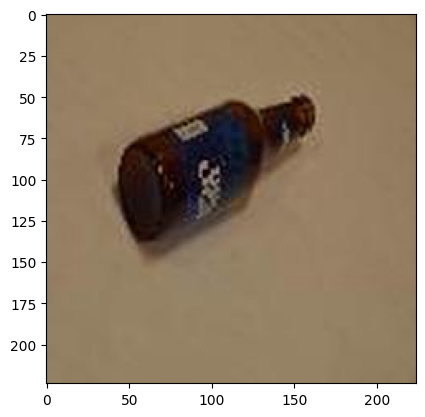

[[5.720816e-04 9.993017e-01 1.262814e-04]]
AluCan : 0.057208159705623984% Glass : 99.93016719818115% PET : 0.012628140393644571%
Real : Glass
Predict : Glass
1/1 [==============================] - 0s 156ms/step


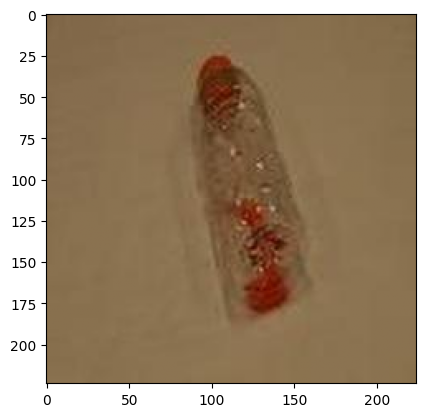

[[0.01661696 0.15643372 0.82694936]]
AluCan : 1.6616957262158394% Glass : 15.643371641635895% PET : 82.69493579864502%
Real : PET
Predict : PET
1/1 [==============================] - 0s 145ms/step


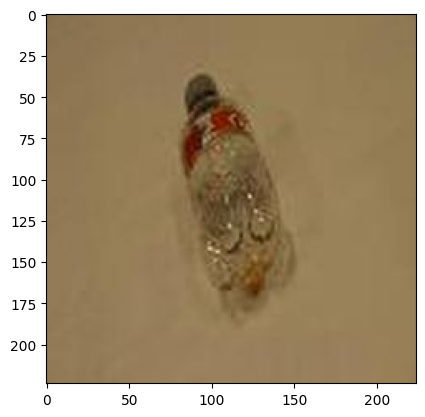

[[0.00131116 0.08647916 0.9122097 ]]
AluCan : 0.13111643493175507% Glass : 8.647916465997696% PET : 91.2209689617157%
Real : PET
Predict : PET
1/1 [==============================] - 0s 150ms/step


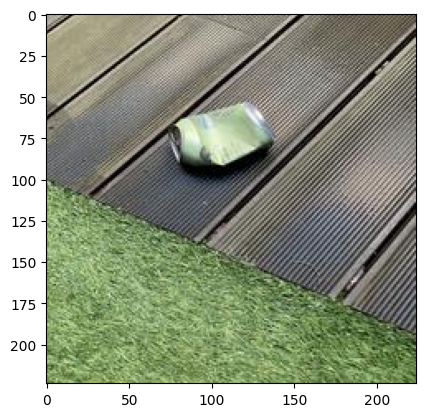

[[9.9962354e-01 7.0455011e-05 3.0596906e-04]]
AluCan : 99.96235370635986% Glass : 0.007045501115499064% PET : 0.03059690643567592%
Real : AluCan
Predict : AluCan
1/1 [==============================] - 0s 145ms/step


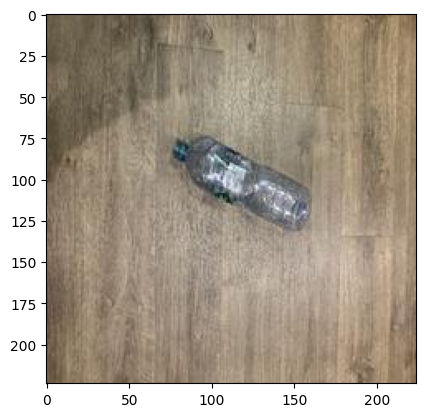

[[2.0239413e-05 2.2744304e-02 9.7723550e-01]]
AluCan : 0.0020239413061062805% Glass : 2.2744303569197655% PET : 97.7235496044159%
Real : PET
Predict : PET
1/1 [==============================] - 0s 147ms/step


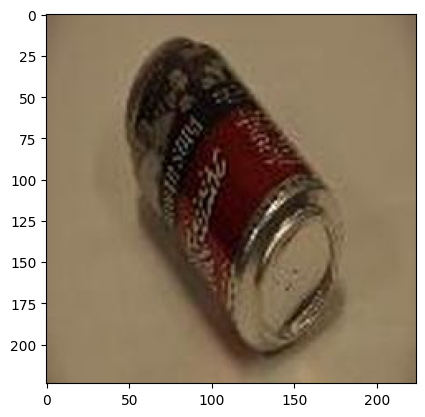

[[9.907985e-01 8.546895e-03 6.547238e-04]]
AluCan : 99.07984733581543% Glass : 0.854689534753561% PET : 0.06547237862832844%
Real : AluCan
Predict : AluCan
1/1 [==============================] - 0s 148ms/step


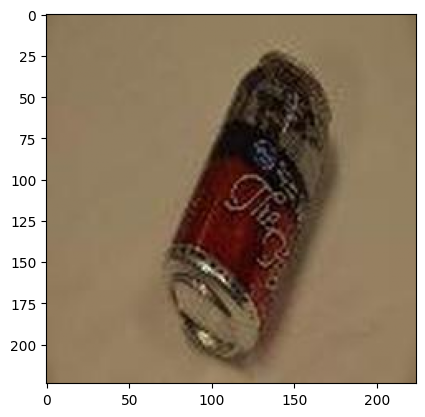

[[9.9920779e-01 7.4378663e-04 4.8449059e-05]]
AluCan : 99.92077946662903% Glass : 0.074378662975505% PET : 0.004844905924983323%
Real : AluCan
Predict : AluCan
1/1 [==============================] - 0s 152ms/step


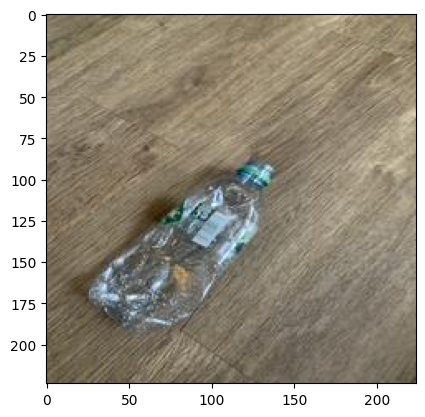

[[3.8614030e-06 2.5398577e-02 9.7459757e-01]]
AluCan : 0.0003861403001792496% Glass : 2.5398576632142067% PET : 97.45975732803345%
Real : PET
Predict : PET
1/1 [==============================] - 0s 144ms/step


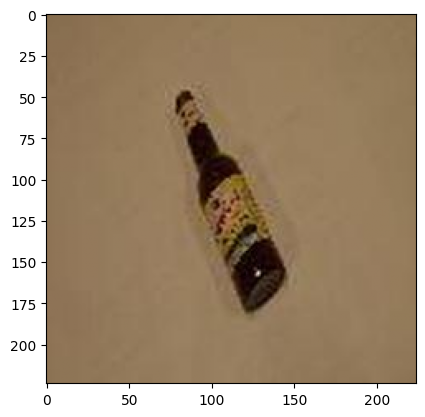

[[2.7756530e-05 9.9594301e-01 4.0291343e-03]]
AluCan : 0.0027756530471378937% Glass : 99.5943009853363% PET : 0.4029134288430214%
Real : Glass
Predict : Glass
1/1 [==============================] - 0s 150ms/step

1/1 [==============================] - 0s 200ms/step
[[9.9996281e-01 2.8500239e-05 8.7460130e-06]]
AluCan : 99.99627685546875%
Glass : 0.0028500237967818975%
PET : 0.0008746013045310974%
Real : AluCan
Predict : AluCan
1/1 [==============================] - 0s 149ms/step

1/1 [==============================] - 0s 200ms/step
[[9.9875534e-01 1.1778761e-03 6.6806111e-05]]
AluCan : 99.87553405761719%
Glass : 0.11778761446475983%
PET : 0.006680611055344343%
Real : AluCan
Predict : AluCan
1/1 [==============================] - 0s 139ms/step

1/1 [==============================] - 0s 200ms/step
[[0.00199021 0.97288346 0.02512637]]
AluCan : 0.19902051985263824%
Glass : 97.28834533691406%
PET : 2.5126373767852783%
Real : Glass
Predict : Glass
1/1 [==============================] - 0s 14

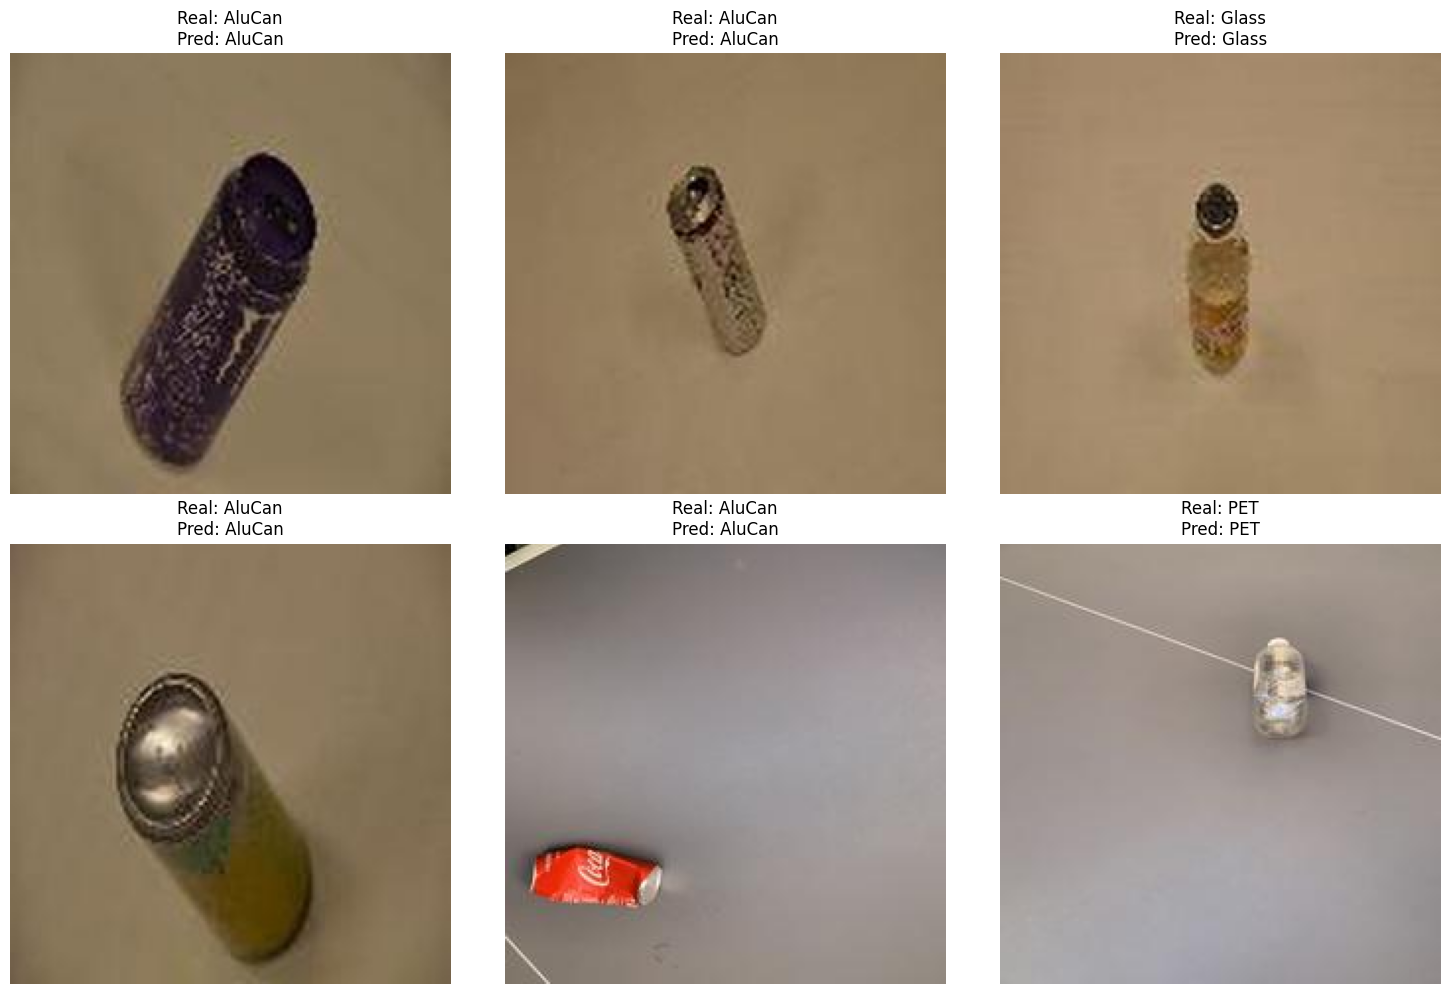

51/51 [==============================] - 160s 3s/step
index of error : 
[  46   53  242  331  384  461  508  517  519  558  643  650  664  679
  685  686  688  689  738  743  787  806  849  867  878  951  952  971
 1015 1023 1042 1102 1111 1157 1206 1211 1314 1320 1341 1350 1384 1401
 1431 1477 1485 1576 1589 1592 1593]

No of errors = 49/1604


In [14]:
visualize_predictions(best_model, 10)
predict_and_visualize(best_model, samples=6)

# Error analysis
predict_x = best_model.predict(np.true_divide(x_test, 255)) 
predictions = np.argmax(predict_x, axis=1)
errors = np.where(predictions != y_test)[0]
print(f"index of error : \n{errors}")
print("\nNo of errors = {}/{}".format(len(errors), len(x_test)))

1/1 [==============================] - 0s 163ms/step


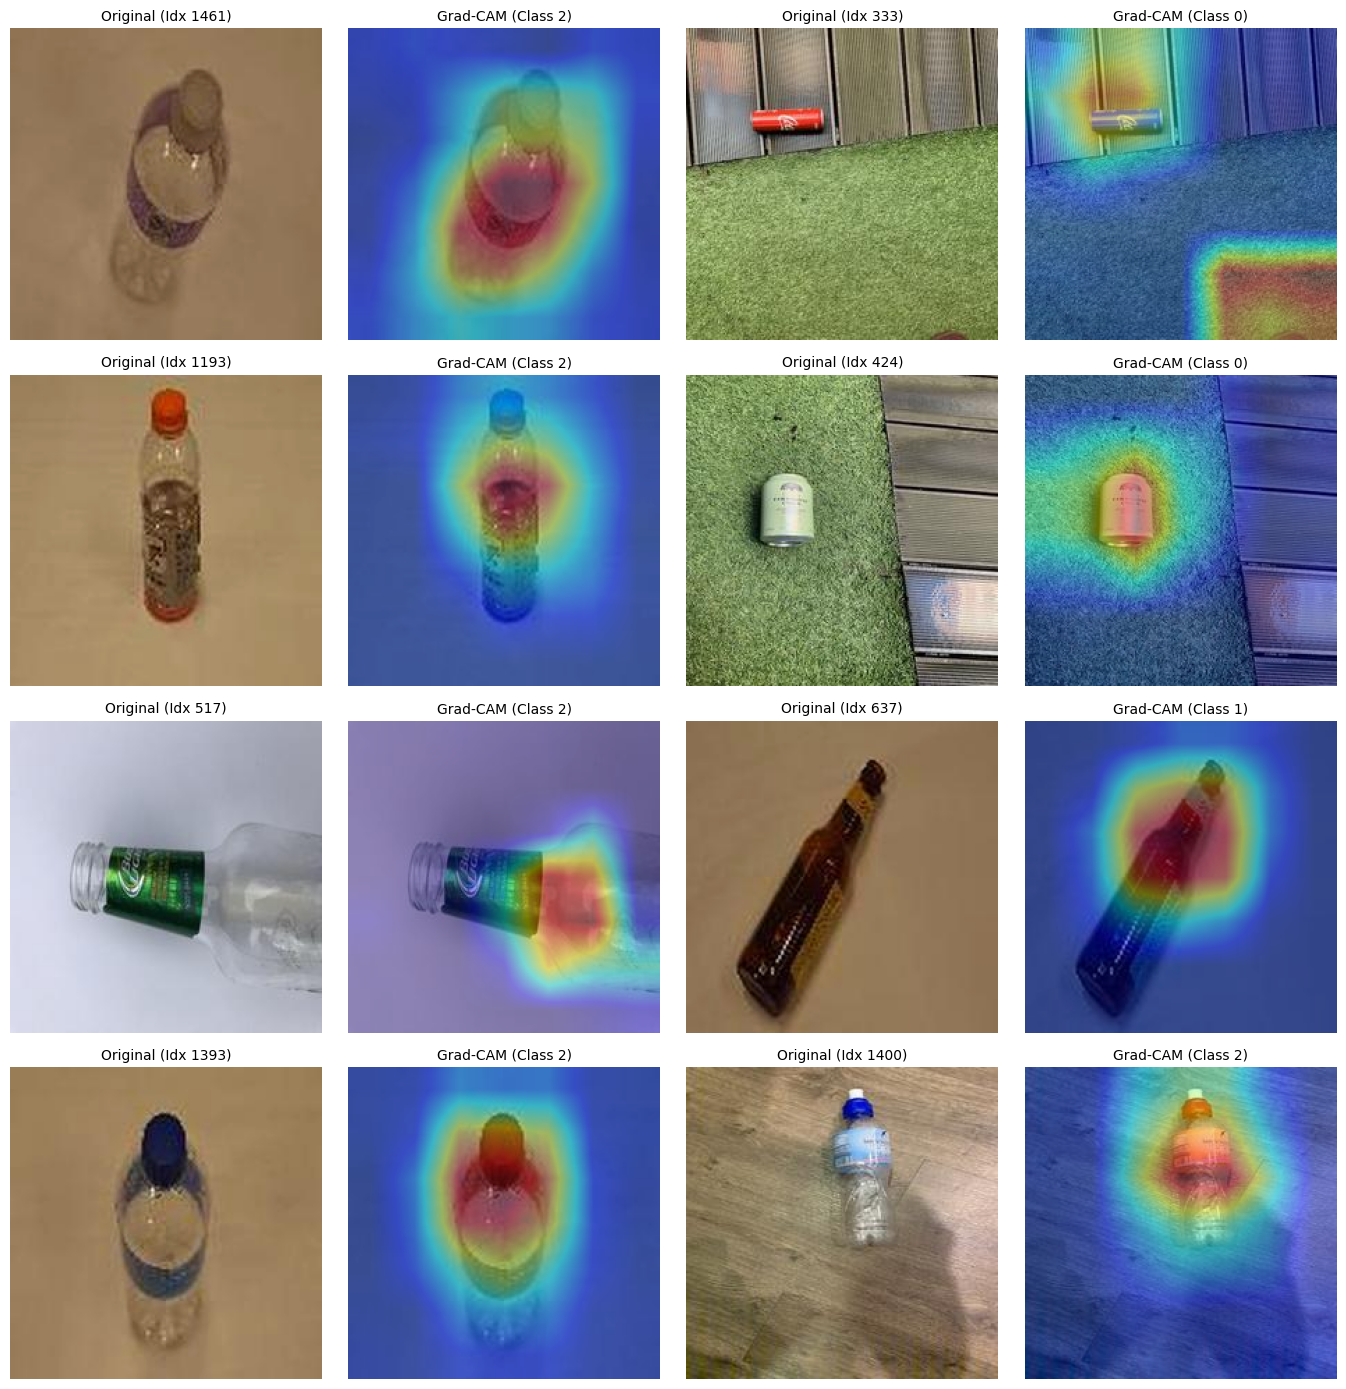

In [18]:
import matplotlib.pyplot as plt

def grad_cam(input_model, image, category_index, layer_name):
    grad_model = tf.keras.models.Model(
        [input_model.inputs],
        [input_model.get_layer(layer_name).output, input_model.output]
    )

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(image)
        loss = predictions[:, category_index]

    grads = tape.gradient(loss, conv_output)[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))

    cam = tf.reduce_sum(tf.multiply(weights, conv_output[0]), axis=-1)
    cam = np.maximum(cam, 0)
    heatmap = cam / (np.max(cam) + 1e-8)
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    original_img = image[0]
    original_img = (original_img - original_img.min()) / (original_img.max() - original_img.min())
    original_img = np.uint8(255 * original_img)

    if original_img.shape[-1] == 1:
        original_img = np.repeat(original_img, 3, axis=-1)

    cam_img = cv2.addWeighted(original_img, 0.6, heatmap, 0.4, 0)

    return cam_img, original_img

# Find last conv layer
last_conv_layer = None
for layer in best_model.layers[::-1]:
    if len(layer.output_shape) == 4:
        last_conv_layer = layer.name
        break

# Plot 8 pairs (original + Grad-CAM)
if last_conv_layer:
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(14, 14))
    fig.subplots_adjust(hspace=0.3, wspace=0.1)

    indices = np.random.choice(len(x_test), 8, replace=False)

    for i, idx in enumerate(indices):
        sample_img = x_test[idx]
        sample_img_preprocessed = np.expand_dims(sample_img / 255., axis=0)
        prediction = best_model.predict(sample_img_preprocessed)
        predicted_class = np.argmax(prediction)

        cam_img, original_img = grad_cam(best_model, sample_img_preprocessed, predicted_class, last_conv_layer)

        row = i // 2
        col = (i % 2) * 2

        axes[row, col].imshow(original_img)
        axes[row, col].set_title(f"Original (Idx {idx})", fontsize=10)
        axes[row, col].axis('off')

        axes[row, col + 1].imshow(cv2.cvtColor(cam_img, cv2.COLOR_BGR2RGB))
        axes[row, col + 1].set_title(f"Grad-CAM (Class {predicted_class})", fontsize=10)
        axes[row, col + 1].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No suitable convolutional layer found.")
